## ML modeling on Enron1 dataset - Spam Detection
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The primary purpose of this notebook is to build four machine learning models - SVM, Logistic Regression, Random Forest and Naive Bayes, and evaluate their performance for the task of text classification. The performance analysis includes the discussion of the possible reasons for low/high accuracy, precision, recall and a short summary of the confusion matrices generated on the 20% test subset of the dataset.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I am expecting to get the best performance metrics using SVM classifier as it handles highly sparse data particularly well by design - SVMs use Kernel trick to get the dot product of the features in high-dimensional spaces, which is a great advantage when dealing with a dataset with 1000+ features. As long as the data is linearly separable in some n-dimensional space, the number of features does not constrain SVM's performance.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since our dataset is imbalanced, I believe that Naive Bayes will not be able to do a good job detecting spam emails, since they are only 30% of the dataset. Naive Bayes classifier tends to be biased when it comes to such imbalances, and it will most likely misclassify a lot of spam emails as non-spam ones.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

In [3]:
df = pd.read_csv('tfidf_dataset.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)

In [4]:
y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

Before feeding the dataset for training of the ML models, it is necessary to scale the features to zero mean and unit variance. Scaling is especially important for the SVM classifier, since without scaling the features SVM's training time increases dramatically.

In [6]:
train = X_train.to_numpy()
train = preprocessing.scale(train) 
test = X_test.to_numpy()
test = preprocessing.scale(test) 
train_l = y_train.to_numpy()
test_l =  y_test.to_numpy()

Let's use grid search for finding the optimal parameters for the proposed ML classifiers and train the classifiers with the parameters determined by grid search.

In [7]:
lr = LogisticRegression(verbose=0)

grid = {"C": [float(i) for i in range(1, 4)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
logreg_cv = GridSearchCV(lr, grid, cv=4)
logreg_cv.fit(train, train_l)

print("\nBest hyperparameters:", logreg_cv.best_params_)
print("Accuracy:", logreg_cv.best_score_)


Best hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9723435225618632


In [8]:
lr = LogisticRegression(solver='lbfgs', penalty ='l2' , C = 1.0)
lr.fit(train, train_l)

pred_lr = lr.predict(test)
print('LR Test Accuracy:', accuracy_score(test_l, pred_lr) * 100)

LR Test Accuracy: 95.635305528613


In [9]:
svc = SVC(verbose=0)
grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_cv = GridSearchCV(svc, grid, cv=5)
svm_cv.fit(train, train_l)

print("\nBest hyperparameters:", svm_cv.best_params_)
print("Accuracy:", svm_cv.best_score_)


Best hyperparameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.9687045123726347


In [10]:
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
svm.fit(train, train_l)

pred_svm = svm.predict(test)
print('SVM Test Accuracy:', accuracy_score(test_l, pred_svm) * 100)

SVM Test Accuracy: 96.5082444228904


In [11]:
RF = RandomForestClassifier(verbose=0)
grid = {'n_estimators': [100, 200, 400], 'criterion': ['entropy', 'gini'],
        'max_depth': [50, 100, 500, 1000], 'class_weight': ['balanced']}

rf_cv = GridSearchCV(RF, grid, cv=5)
rf_cv.fit(train, train_l)

print("\nBest hyperparameters:", rf_cv.best_params_)
print("Accuracy:", rf_cv.best_score_)


Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1000, 'n_estimators': 200}
Accuracy: 0.9713731198447355


In [12]:
RF = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=1000, n_estimators=100)
RF.fit(train, train_l)

pred_rf = RF.predict(test)
print('RF Test Accuracy:', accuracy_score(test_l, pred_rf) * 100)

RF Test Accuracy: 96.99321047526674


In [13]:
NB = GaussianNB(priors=(0.7, 0.3))
NB.fit(train, train_l)

pred_nb = NB.predict(test)
print('NB Test Accuracy:', accuracy_score(test_l, pred_nb) * 100)

NB Test Accuracy: 85.64500484966052


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As predicted prior to the training phase, Random Forest and SVM reached the best classification accuracy that is manifested in the confusion matrices of all the classifiers' test results when compared against each other. Naive Bayes performed subpar, classifying only 85% of the emails correctly, and misclassifying almost half of all the spam emails in the dataset as non-spam emails, which confirms its bias towards a class with a greater number of examples.\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall, the differences in the performances of SVM, Random Forest, and Logistic Regression classifiers are not substantial with all the three classifiers producing >95% accuracy results.

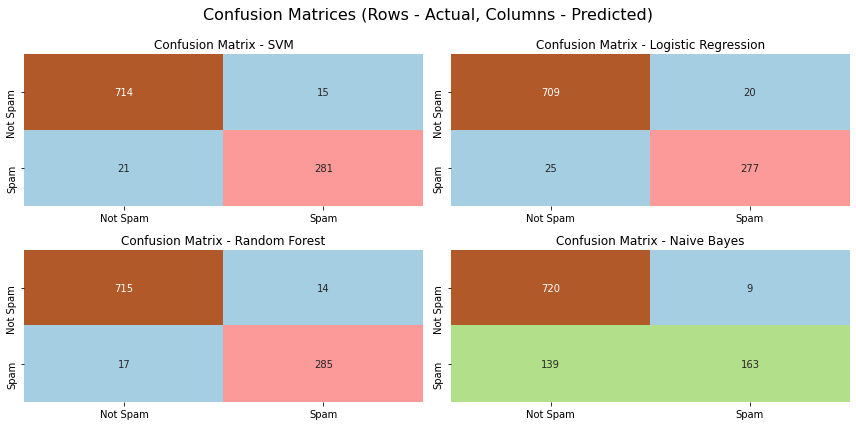

In [16]:
cmat_svm = confusion_matrix(test_l, pred_svm)
cmat_lr = confusion_matrix(test_l, pred_lr)
cmat_rf = confusion_matrix(test_l, pred_rf)
cmat_nb = confusion_matrix(test_l, pred_nb)
fig = plt.figure(figsize=(12,6))
fig.suptitle('Confusion Matrices (Rows - Actual, Columns - Predicted)', fontsize=16);
plt.subplot(2, 2, 1)
plt.title('\n\nConfusion Matrix - SVM')
sns.heatmap(cmat_svm, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 2)
plt.title('Confusion Matrix - Logistic Regression')
sns.heatmap(cmat_lr, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix - Random Forest')
sns.heatmap(cmat_rf, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix - Naive Bayes')
sns.heatmap(cmat_nb, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.tight_layout()
plt.savefig('cm.png')

In [17]:
print('Classification Report - LR:\n', classification_report(test_l, pred_lr),
      '\nClassification Report - SVM:\n', classification_report(test_l, pred_svm),
     '\nClassification Report - RF:\n', classification_report(test_l, pred_rf),
     '\nClassification Report - NB:\n', classification_report(test_l, pred_nb))

Classification Report - LR:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       729
           1       0.93      0.92      0.92       302

    accuracy                           0.96      1031
   macro avg       0.95      0.94      0.95      1031
weighted avg       0.96      0.96      0.96      1031
 
Classification Report - SVM:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       729
           1       0.95      0.93      0.94       302

    accuracy                           0.97      1031
   macro avg       0.96      0.95      0.96      1031
weighted avg       0.96      0.97      0.96      1031
 
Classification Report - RF:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       729
           1       0.95      0.94      0.95       302

    accuracy                           0.97      1031
   macro avg       0.96      0.96     